# An Implementation of Transformer in Translation from English to Chinese

### 0.Import some dependences & set some parameters

In [1]:
import os
import math
import copy
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# here, use `pip install nltk` `python -m nltk.downloader punkt` `python -m nltk.downloader popular`
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt


In [2]:
UNK = 0                  # unknown word id
PAD = 1                  # padding word id
BATCH_SIZE = 32
EPOCHS = 20
LAYERS = 6               # number of encoder & decoder layers
H_NUM = 8                # number of multihead attention hidden
D_MODEL = 256            # dimentions of embbeding
D_FF = 1024              # dimentions of first full connection in feed forward
DROPOUT = .1             # rate of dropout
MAX_LENGTH = 60          # maxium length of a sentence
MAX_WORDS = int(5*1e4)   # maxium words of a dictionary
MAX2TRAIN = int(1e6)     # maxium scentences to train
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
TRAIN_FILE = './translation2019zh/translation2019zh_train.json'
DEV_FILE = './translation2019zh/translation2019zh_valid.json'
SAVE_FILE = './model_L.pt'


### 1.Data Preparation(tokenize, word2id, add padding & mask, batchnize)

In [3]:
def seq_padding(X, padding=0):
    '''
    Fill 0 into the other of the sentence if the length of it is lower than 
    ML(the max length of scentence in a batch)
    '''
    ML = max([len(x) for x in X])
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])


def subsequent_mask(size):
    '''
    Mask out subsequent positions.
    '''
    mask_shape = (1, size, size)
    # generate a matrix with all 1s in the upper-right corner (excluding the main diagonal),
    # and 0s in the lower-left corner (including the main diagonal)
    # [[0 1 1]
    #  [0 0 1]
    #  [0 0 0]]
    sub_mask = np.triu(np.ones(mask_shape), k=1).astype('uint8')
    # return a matrix with all False in the upper-right corner (excluding the main diagonal),
    # and True in the lower-left corner (including the main diagonal)
    # [[True False False]
    #  [True True  False]
    #  [True True  True]]
    return torch.from_numpy(sub_mask) == 0


class Batch:
    '''
    Object for holding a batch of data with mask during training.
    '''
    def __init__(self, src, tgt=None, pad=0):
        src = torch.from_numpy(src).cuda().long() # [bs, sen_length]
        tgt = torch.from_numpy(tgt).cuda().long() # [bs, sen_length]
        self.src = src

        self.src_mask = (src != pad).unsqueeze(-2) # seq_length -> [1, seq_length]

        if tgt is not None:
            self.tgt = tgt[:, :-1] # input of decoder excluding <EOS>
            self.tgt_y = tgt[:, 1:] # output of decoder excluding <BOS>
            self.tgt_mask = self.make_std_mask(self.tgt, pad) # mask some place of target input
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        '''
        Create a mask to hide padding and future words.
        '''
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask


class PrepareData:
    '''
    txt -> [batch_size, sequence_length]
    '''

    def __init__(self, train_file, dev_file):
        # load data, divide them into source and target, and tokenized them
        print('load_data...')
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)

        # build word dictionary using train data
        print('build_dict...')
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # word2id
        print('word2id...')
        self.train_en_id, self.train_cn_id = self.word2id(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en_id, self.dev_cn_id = self.word2id(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)

        # split batch + padding + mask
        print('splitBatch...')
        self.train_data = self.splitBatch(self.train_en_id, self.train_cn_id, BATCH_SIZE)
        self.dev_data = self.splitBatch(self.dev_en_id, self.dev_cn_id, BATCH_SIZE)


    def load_data(self, path):
        '''
        en = [['<BOS>', 'i', 'love', 'you', '<EOS>'], ['<BOS>', 'me', 'too', '<EOS>'], ...]
        cn = [['<BOS>', '我', '爱', '你', '<EOS>'], ['<BOS>', '我', '也', '是', '<EOS>'], ...]
        where <BOS> means Begin Of Sentence, and <EOS> means End Of Sentence
        '''
        en, cn = [], []
        with open(path, 'r', encoding='utf-8') as f:
            cnt = 0
            for line in f:
                cnt += 1
                line_content = line.replace('\\"', '\'').split('"')
                # print(line_content) # ['Anyone can do that.', '任何人都可以做到。\n']
                try:
                    en.append(['<BOS>'] + word_tokenize(line_content[3]) + ['<EOS>'])
                except:
                    continue
                try:
                    cn.append(['<BOS>'] + word_tokenize(' '.join(line_content[7])) + ['<EOS>']) # !!! attention to the space between ' '
                except:
                    en.pop()
                    continue
                if (cnt) % MAX2TRAIN == 0:
                    print(f'len(en): {len(en)}\tlen(cn): {len(cn)}')
                    break
            # print(en)
            # print(cn)
            print(f'Number of paired data to train/valid is {cnt}')
        return en, cn


    def build_dict(self, sentences, max_words=MAX_WORDS):
        '''
        word_dict = {key(word): value(id)}
        total_words = len(most_common_words) + 2
        index_dict = {key(id): value(word)}
        '''
        word_count = Counter()
        for sentence in sentences:
            for w in sentence:
                word_count[w] += 1
        # just keep most common max_words number words
        most_common_words = word_count.most_common(max_words)
        total_words = len(most_common_words) + 2 # including <UNK> & <PAD>
        print(f'total_words {total_words}')
        word_dict = {w[0]: idx + 2 for idx, w in enumerate(most_common_words)}
        word_dict['<UNK>'] = UNK
        word_dict['<PAD>'] = PAD
        index_dict = {v: k for k, v in word_dict.items()}

        return word_dict, total_words, index_dict


    def word2id(self, en, cn, en_dict, cn_dict, sort=True):
        '''
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]
        and then sorted according the length of sentence in English sentences sequence
        '''
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]

        def len_argsort(seq):
            '''
            return idx of the sentence in the before sentences sequence sorting from short to long
            '''
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))

        if sort:
            sorted_idx = len_argsort(out_en_ids)
            out_en_ids = [out_en_ids[i] for i in sorted_idx]
            out_cn_ids = [out_cn_ids[i] for i in sorted_idx]

        return out_en_ids, out_cn_ids

        
    def splitBatch(self, en_id, cn_id, batch_size, shuffle=True):
        '''
        split pairs of en_id/cn_id by specified batch_size
        '''
        idx_list = np.arange(0, len(en_id), batch_size)
        if shuffle: np.random.shuffle(idx_list)

        batch_idxs = []
        for idx in idx_list:
            # in case idx + bs > len(en_id) in the last batch
            batch_idxs.append(np.arange(idx, min(idx + batch_size, len(en_id))))

        batches = []
        for batch_idx in batch_idxs:
            batch_en = [en_id[idx] for idx in batch_idx]
            batch_cn = [cn_id[idx] for idx in batch_idx]
            batch_en = seq_padding(batch_en) # nbatch * batchsize * seqlen
            batch_cn = seq_padding(batch_cn)
            batches.append(Batch(batch_en, batch_cn))

        return batches


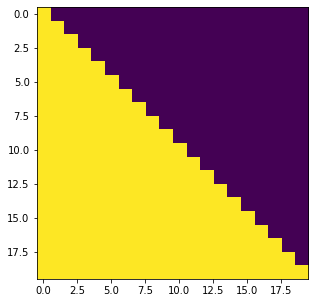

In [4]:
# have a look the matrix of mask
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])


### 2.Input Embedding

$$InputEmbedding(x) = Embedding(x) * \sqrt {d_{model}}$$

In [5]:
class InputEmbedding(nn.Module):
    def __init__(self, d_model, vocablen):
        super(InputEmbedding, self).__init__()
        self.emb = nn.Embedding(vocablen, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)
        

### 3.Positional Encoding

$$PE_{(pos, 2i)} = \sin (\frac{pos}{1000^{\frac{2i}{d_{model}}}})$$
$$PE_{(pos, 2i+1)} = \cos (\frac{pos}{1000^{\frac{2i}{d_{model}}}})$$

In [6]:
class PositionalEncoding(nn.Module):
    '''
    '''
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dp = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model).cuda() # [max_len, d_model]
        position = torch.arange(0, max_len).cuda().unsqueeze(1) # [max_len, 1]
        div_term = torch.exp(torch.arange(0., d_model, 2).cuda() * -(math.log(10000.0) / d_model))
        # pe = torch.zeros(max_len, d_model, device=DEVICE) # [max_len, d_model]
        # position = torch.arange(0, max_len, device=DEVICE).unsqueeze(1) # [max_len, 1]
        # div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) # PE_(pos, 2i) = sin(pos/(10000^(2i/d_model)))
        pe[:, 1::2] = torch.cos(position * div_term) # PE_(pos, 2i+1) = cos(pos/(10000^(2i/d_model)))
        pe = pe.unsqueeze(0) # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dp(x + Variable(self.pe[:, :x.size(1)], requires_grad=False))
        

### 4.Multi-Head Attention

$$
\begin{align*}
	Q &= Linear(X) = X * W_Q\\
	K &= Linear(X) = X * W_K\\
	V &= Linear(X) = X * W_V\\
	Attention(X) &= SelfAttention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
\end{align*}
$$

In [7]:
def attention(query, key, value, mask=None, dropout=None):

    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None: scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None: p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h # No. of heads
        # 4 full connect function as WQ, WK, WV, multihead concat matrix
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dp = nn.Dropout(p=dropout)


    def forward(self, query, key, value, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # [bs, h, len, dim/h]
        q, k, v = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                    for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dp)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
        

### 5.LayerNorm

$$LayerNorm(x) = \alpha * \frac{x_{ij} - \mu_{i}}{\sqrt{\sigma _i^2 + \epsilon}} + \beta$$

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        # init all alpha = 1, all beta = 0
        self.alpha = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        # smooth
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.alpha * (x - mean) / torch.sqrt(std ** 2 + self.eps) + self.beta


### 6.Positionwise FeedForward

$$PositionwiseFeedForward(X_{attn}) = Linear(Activate(Linear(X_{attn})))$$

In [9]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.w_2(self.dropout(self.act(self.w_1(x))))
        

### 7.Utilities class: SublayerConnection & clones

$$SublayerConnection(X) = X + SubLayer(X)$$

In [10]:
class SublayerConnection(nn.Module):
    '''
    First, connect x and norm
    Finally, connect MultiHeadAttention and PositionwiseFeedForward
    '''
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
        # return x + self.dropout(self.norm(sublayer(x))) # ?


def clones(module, N):
    '''
    clone the module not sharing the parameters
    '''
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


### 8.EncoderLayer & Encoder(N_head EncoderLayers)

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        # embedding -> Multi head Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # attn -> feedforward
        return self.sublayer[1](x, self.feed_forward)


class Encoder(nn.Module):
    # layer = EncoderLayer
    # N = 6
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # clone N encoder_layers
        self.layers = clones(layer, N)
        # LayerNorm for encoder_layer
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        # Attention: mask for x
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
        

### 9.DecoderLayer & Decoder(N_head DecoderLayers)

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        # Self-Attention
        self.self_attn = self_attn
        # Context-Attention with context from encoder
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 1.sef-attention, 2.context-attention, 3.feedforward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # m save the result of hidden of encoder
        m = memory        
        # Self-Attention：q, k, v from decoder hidden
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # Context-Attention：q from decoder hidden，k, v from encoder hidden
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


class Decoder(nn.Module):
    # layer = DecoderLayer
    # N = 6
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        # clone N decoder_layer
        self.layers = clones(layer, N)
        # LayerNorm for decoder_layer
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        # Attention: mask for src & tgt
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
        

### 10.Transformer

<img src='https://pic1.zhimg.com/80/v2-4b53b731a961ee467928619d14a5fd44_720w.jpg' text-align='center'/>

#### 10.1.Encoder

- 1).InputEmbedding + PositionalEncoding

$$X_{emb} = InputEmbedding(X) + PositionalEncoding(pos)$$

- 2).MultiHeadSelfAttention

$$X_{attn} = MHA(X_{emb}) = Concatenate(Attention_i(X_{emb})) * W_C$$
$$i = [1, numheads]$$
$$
\begin{align*}
	Q &= Linear(X) = X * W_Q\\
	K &= Linear(X) = X * W_K\\
	V &= Linear(X) = X * W_V
\end{align*}
$$
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

- 3).SublayerConnection + Norm

$$X_{attn} = LayerNorm(X_{attn})$$
$$X_{attn} = X + X_{attn}$$

- 4).PositionwiseFeedForward

$$X_{hidden} = Linear(Activate(Linear(X_{attn})))$$

- 5).Repeat 3)

$$X_{hidden} = LayerNorm(X_{hidden})$$
$$X_{hidden} = X_{attn} + X_{hidden}$$

- 6).Repeat 2) ~ 5) * N 

	Let the output of previous 5) be the input of next 2), repeating N times.

#### 10.2.Decoder

- 1).InputEmbedding + PositionalEncoding

$$Y_{emb} = InputEmbedding(Y) + PositionalEncoding(pos)$$

- 2).MultiHeadSelfAttention

$$Y_{attn1} = MaskedMHA(Y_{emb}) = Concatenate(Attention_i(Y_{emb})) * W_C$$
$$i = [1, numheads]$$
$$
\begin{align*}
	Q &= Linear(Y) = Y * W_Q\\
	K &= Linear(Y) = Y * W_K\\
	V &= Linear(Y) = Y * W_V
\end{align*}
$$
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

- 3).SublayerConnection + Norm

$$Y_{attn1} = LayerNorm(Y_{attn1})$$
$$Y_{attn1} = Y + Y_{attn1}$$

- 4).MultiHeadContextAttention

$$Y_{attn2} = MHA(Y_{attn1}, M) = Concatenate(Attention_i(Y_{attn1}, M)) * W_C$$
$$i = [1, numheads], M = X_{hidden}$$
$$
\begin{align*}
	Q &= Linear(Y_{attn1}) = Y_{attn1} * W_Q\\
	K &= Linear(M) = X_{hidden} * W_K\\
	V &= Linear(M) = X_{hidden} * W_V
\end{align*}
$$
$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

- 5).Repeat 3)

$$Y_{attn2} = LayerNorm(Y_{attn2})$$
$$Y_{attn2} = Y + Y_{attn2}$$

- 6).PositionwiseFeedForward

$$Y_{hidden} = Linear(Activate(Linear(Y_{attn2})))$$

- 7).Repeat 3)

$$Y_{hidden} = LayerNorm(Y_{hidden})$$
$$Y_{hidden} = Y_{attn2} + Y_{hidden}$$

- 8).Repeat 2) ~ 7) * N 

	Let the output of previous 7) be the input of next 2), repeating N times.

#### 10.3.linear + log_softmax

In [13]:
class Generator(nn.Module):
    # vocab: tgt_vocab
    def __init__(self, d_model, vocab_len):
        super(Generator, self).__init__()
        # let the result of decoder be the size from d_model to vocab_len
        self.proj = nn.Linear(d_model, vocab_len)

    def forward(self, x):
        # softmax + log
        return F.log_softmax(self.proj(x), dim=-1)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator 

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        # let the result of encoder as the input parameter(memory) of decoder
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
        

### 11.Make a real Transformer model

In [14]:
def make_model(src_vocab_len, tgt_vocab_len, N=LAYERS, h=H_NUM, d_model=D_MODEL*2, d_ff=D_FF*2, dropout=DROPOUT):
    '''
    Instantiation model
        param:
            src_vocab, tgt_vocab: word_dict = {key(word): value(id)}
            src_vocab_len, tgt_vocab_len: len of src_vocab, tgt_vocab
            N: # of layers in encoder or decoder
            h: # of heads in multi-head attention
            d_model: dimentions of embbeding
            d_ff: dimentions of first full connection in feed forward
            dropout: rate of dropout
        return:
            model
    '''
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model).cuda()
    pe = PositionalEncoding(d_model, dropout).cuda()
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).cuda()

    model = nn.DataParallel(Transformer(
        encoder=Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).cuda(), N).cuda(),
        decoder=Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).cuda(), N).cuda(),
        src_embed=nn.Sequential(InputEmbedding(d_model, src_vocab_len).cuda(), c(pe)),
        tgt_embed=nn.Sequential(InputEmbedding(d_model, tgt_vocab_len).cuda(), c(pe)),
        generator=Generator(d_model, tgt_vocab_len)
    )).cuda()

    # model = Transformer(
    #     encoder=Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).cuda(), N).cuda(),
    #     decoder=Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).cuda(), N).cuda(),
    #     src_embed=nn.Sequential(InputEmbedding(d_model, src_vocab_len).cuda(), c(pe)),
    #     tgt_embed=nn.Sequential(InputEmbedding(d_model, tgt_vocab_len).cuda(), c(pe)),
    #     generator=Generator(d_model, tgt_vocab_len)
    # ).cuda()

    # This was important from the code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # use nn.init.xavier_uniform
            nn.init.xavier_uniform_(p)

    return model.cuda()


---

### 12.Smooth the label(implement by KLdivloss)

In [15]:
class LabelSmoothing(nn.Module):
    '''
    smooth the label
    '''
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.size = size
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.padding_idx = padding_idx
        self.true_dist = None
        self.criterion = nn.KLDivLoss(reduction='sum')
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


### 13.Compute the loss

In [16]:
class LossComputing:
    '''
    compute loss and update the parameters by backpropagation
    '''
    def __init__(self, generator, criterion, optim=None):
        self.generator = generator
        self.criterion = criterion
        self.optim = optim

    def __call__(self, pred, gt, ntokens):
        x = self.generator(pred)
        y = gt
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / ntokens
        loss.backward()
        if self.optim is not None:
            self.optim.step()
            self.optim.optimizer.zero_grad()
        return loss.data.item() * ntokens.float()
        

### 14.Set optimizer with a warmupdown learning rate

$$lr = lr_{base} * [d_{model}^{-.5} * \min{(step\_ num^{-.5}, step\_ num*warmup\_  steps^{-1.5})}]$$

The lr increases linearly with a fixed warmup_steps, decreases proportional to the inverse square root of step_num when it reached warmup_steps(here is 4000).

The base optimizer is Adam with beta1=.9, beta2=.98, epsilon=1e-9.

In [17]:
class NoamOpt:
    '''
    Optim wrapper that implements rate.
    '''
    def __init__(self, model_size, factor, warmup, optimizer):
        self.model_size = model_size  # d_model
        self.factor = factor          # lr_base
        self.warmup = warmup          # warmup_steps
        self.optimizer = optimizer
        self._step = 0
        self._rate = 0

    def rate(self, step=None):
        'Implement the lr above'
        if step is None: step = self._step
        return self.factor * (self.model_size ** (-.5) * min(step ** (-.5), step * self.warmup ** (-1.5)))

    def step(self):
        '''
        update parameters and rate
        '''
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups: p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        

def get_std_opt(model):

    return NoamOpt(
        model_size=model.src_embed[0].d_model,
        factor=2,
        warmup=4000,
        optimizer=torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
    )


### 15.Train and Validation

In [18]:
def run_epoch(data, model, loss_compute, epoch):
    '''
    run one epoch of train
    '''

    start = datetime.now()
    total_loss = 0.
    tokens = 0
    total_tokens = 0
    
    datalen = len(data)
    roundnum = datalen // (10 ** math.floor(math.log10(datalen))) * (10 ** math.floor(math.log10(datalen)))
    steplen = roundnum // 4

    for i, batch in enumerate(data):
        out = model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
        loss = loss_compute(out, batch.tgt_y, batch.ntokens)

        total_loss += loss
        tokens += batch.ntokens
        total_tokens += batch.ntokens

        # if (i + 1) % 50 == 0:
        if (i + 1) % steplen == 0:
            elapsed = datetime.now() - start
            print(f'Epoch: {epoch+1} / {EPOCHS} Batch: {i+1} Loss: {loss / batch.ntokens} Tokens per Sec: {tokens.float() / elapsed.total_seconds()}')
            start = datetime.now()
            tokens = 0
    
    return total_loss / total_tokens


def train(data, model, criterion, optimizer):
    '''
    run EPOCHS epoch of train
    '''

    print(">>>>>>>>>> Start training...\n")
    train_start = datetime.now()
    best_dev_loss = 1e5 # init a higher dev_loss
    
    for epoch in range(EPOCHS):

        epoch_start = datetime.now()

        model.train()
        run_epoch(data.train_data, model, LossComputing(model.module.generator, criterion, optimizer), epoch)
        # run_epoch(data.train_data, model, LossComputing(model.generator, criterion, optimizer), epoch)

        model.eval()
        print('>>>>> Evaluate...')
        dev_loss = run_epoch(data.dev_data, model, LossComputing(model.module.generator, criterion, None), epoch)
        # dev_loss = run_epoch(data.dev_data, model, LossComputing(model.generator, criterion, None), epoch)
        print(f'>>>>> Evaluate loss {dev_loss}')
        
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), SAVE_FILE)
            best_dev_loss = dev_loss

        print(f'One epoch cost {datetime.now()-epoch_start}.\n')
    
    print(f'<<<<<<<<<< Finished training, cost {datetime.now()-train_start}.')
    

In [19]:
# load data
data = PrepareData(TRAIN_FILE, DEV_FILE)

src_vocab_len = len(data.en_word_dict)
tgt_vocab_len = len(data.cn_word_dict)

en_word_dict = data.en_word_dict

print(f'src_vocab_len: {src_vocab_len}')
print(f'tgt_vocab_len: {tgt_vocab_len}')

# init model
model = make_model(
    src_vocab_len=src_vocab_len,
    tgt_vocab_len=tgt_vocab_len,
    N=LAYERS,
    h=H_NUM,
    d_model=D_MODEL,
    d_ff=D_FF,
    dropout=DROPOUT
)

criterion = LabelSmoothing(tgt_vocab_len, padding_idx=0, smoothing=0.0)
optimizer = NoamOpt(
    model_size=D_MODEL,
    factor=1,
    warmup=4000,
    optimizer=torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
)


load_data...
len(en): 1000000	len(cn): 1000000
Number of paired data to train/valid is 1000000
Number of paired data to train/valid is 39323
build_dict...
total_words 50002
total_words 8204
word2id...
splitBatch...
src_vocab_len: 50002
tgt_vocab_len: 8204


In [20]:
train(data, model, criterion, optimizer)

>>>>>>>>>> Start training...



c:\Users\siat\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch: 1 / 20 Batch: 7500 Loss: 3.91288423538208 Tokens per Sec: 5880.43115234375
Epoch: 1 / 20 Batch: 15000 Loss: 3.599436044692993 Tokens per Sec: 5834.32080078125
Epoch: 1 / 20 Batch: 22500 Loss: 3.337946891784668 Tokens per Sec: 5809.421875
Epoch: 1 / 20 Batch: 30000 Loss: 3.017076253890991 Tokens per Sec: 5627.42919921875
>>>>> Evaluate...
Epoch: 1 / 20 Batch: 250 Loss: 2.609365224838257 Tokens per Sec: 6593.0498046875
Epoch: 1 / 20 Batch: 500 Loss: 3.1945793628692627 Tokens per Sec: 6552.2958984375
Epoch: 1 / 20 Batch: 750 Loss: 2.597550630569458 Tokens per Sec: 7050.60986328125
Epoch: 1 / 20 Batch: 1000 Loss: 2.902169704437256 Tokens per Sec: 6304.05712890625
>>>>> Evaluate loss 2.885564088821411
One epoch cost 1:48:46.148399.

Epoch: 2 / 20 Batch: 7500 Loss: 2.917682647705078 Tokens per Sec: 5674.03564453125
Epoch: 2 / 20 Batch: 15000 Loss: 3.0629422664642334 Tokens per Sec: 5734.935546875
Epoch: 2 / 20 Batch: 22500 Loss: 2.952914237976074 Tokens per Sec: 5686.22705078125
Epoch

### 16.Prediction or say Translation

In [20]:
from nltk.translate.bleu_score import sentence_bleu

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    '''
    predict tgtids from src(one sentence)
    '''
    # encode src
    # memory = model.encode(
    memory = model.module.encode(
        src=src,
        src_mask=src_mask
    )
    preds = torch.ones(1, 1).fill_(start_symbol).type_as(src.data) # 1*1, fill id of '<BOS>', LongTensor
    for _ in range(max_len-1):
        # decode src, tgt
        # out = model.decode(
        out = model.module.decode(
            memory=memory,
            src_mask=src_mask,
            tgt=Variable(preds),
            tgt_mask=Variable(subsequent_mask(preds.size(1)).type_as(src.data))
        )
        # hidden repretation -> probability of log_softmax for words in dict
        prob = model.module.generator(out[:, -1]) # excluding '<EOS>'
        # prob = model.generator(out[:, -1]) # excluding '<EOS>'
        # get next prediction id of current position max probability
        _, next_word_id = torch.max(prob, dim=1) # [id]
        next_word_id = next_word_id.data[0] # id
        preds = torch.cat([preds, torch.ones(1, 1).type_as(src.data).fill_(next_word_id)], dim=1)

    return preds


def translate(data, model):
    '''
    predict tgts id and print words
    '''
    fw = open('./translation_L.txt', 'a', encoding="utf-8")
    print(">>>>>>>>>> Start translating\n")
    fw.write(">>>>>>>>>> Start translating\n\n")
    translate_start = datetime.now()

    with torch.no_grad():
        total_BLEU4 = 0
        total_BLEU2 = 0
        len_dev = len(data.dev_en_id)
        cost_time = datetime.now() - datetime.now()

        for i in range(len_dev):
            one_translate_start = datetime.now()
            # print(f'idx / len_dev: {i+1} / {len_dev}')
            fw.write(f'idx / len_dev: {i+1} / {len_dev}\n')

            # source sentence
            src_sent_list = [data.en_index_dict[w] for w in data.dev_en_id[i]]
            src_sent = ' '.join(src_sent_list)
            # print(f'source_sentence: {src_sent}')
            fw.write(f'source_sentence: {src_sent}\n')

            # target sentence
            tgt_sent_list = [data.cn_index_dict[w] for w in data.dev_cn_id[i]]
            tgt_sent = ' '.join(tgt_sent_list)
            # print(f'target_sentence: {tgt_sent}')
            fw.write(f'target_sentence: {tgt_sent}\n')

            # translate
            src = torch.from_numpy(np.array(data.dev_en_id[i])).long().cuda().unsqueeze(0)
            src_mask = (src != 0).unsqueeze(-2)
            out = greedy_decode(
                model=model,
                src=src,
                src_mask=src_mask,
                max_len=MAX_LENGTH,
                start_symbol=data.cn_word_dict['<BOS>']
            )
            translation = [] # for one sentence
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym != '<EOS>': translation.append(sym)
                else: break
            # print(f'translation: {" ".join(translation)}')
            fw.write(f'translation: {" ".join(translation)}\n')

            # compute BLEU
            # 4-gram cumulative BLEU
            # >>> from nltk.translate.bleu_score import sentence_bleu
            # >>> reference = [['this', 'is', 'small', 'test']]
            # >>> candidate = ['this', 'is', 'a', 'test']
            # >>> score = sentence_bleu(reference, candidate)
            score4 = sentence_bleu([tgt_sent_list], translation)
            score2 = sentence_bleu([tgt_sent_list], translation, weights=(0.75, 0.25, 0, 0))
            total_BLEU4 += score4
            total_BLEU2 += score2
            # print(f'BLEU score4: {score4}')
            # print(f'BLEU score2: {score2}\n')
            fw.write(f'BLEU score4: {score4}\n')
            fw.write(f'BLEU score2: {score2}\n\n')
            cost_time += datetime.now() - one_translate_start

            freq = 1e3
            if (i+1) % freq == 0:
                print(f'Translation cost {cost_time} per {freq} sentences.\n')
                fw.write(f'Translation cost {cost_time} per {freq} sentences.\n\n')
                cost_time = datetime.now() - datetime.now()

        avg_BLEU4 = total_BLEU4 / len_dev
        avg_BLEU2 = total_BLEU2 / len_dev
        print(f'average_BLEU4: {avg_BLEU4}')
        print(f'average_BLEU2: {avg_BLEU2}')
        fw.write(f'average_BLEU4: {avg_BLEU4}\n')
        fw.write(f'average_BLEU2: {avg_BLEU2}\n')

    print(f'<<<<<<<<<< Finished translating, cost {datetime.now()-translate_start}.')
    fw.write(f'<<<<<<<<<< Finished translating, cost {datetime.now()-translate_start}.\n')

In [21]:
# load the weights of model
model.load_state_dict(torch.load(SAVE_FILE))
# translation
translate(data, model)

>>>>>>>>>> Start translating



c:\Users\siat\AppData\Local\Programs\Python\Python38\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\siat\AppData\Local\Programs\Python\Python38\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\siat\AppData\Local\Programs\Python\Python38\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower orde

Translation cost 0:10:52.183882 per 100 sentences.

Translation cost 0:10:49.735061 per 100 sentences.

Translation cost 0:10:52.295248 per 100 sentences.

Translation cost 0:11:05.141149 per 100 sentences.

Translation cost 0:11:02.627910 per 100 sentences.

Translation cost 0:11:03.319644 per 100 sentences.

Translation cost 0:11:02.429118 per 100 sentences.

Translation cost 0:11:05.408113 per 100 sentences.

Translation cost 0:10:49.384477 per 100 sentences.

Translation cost 0:10:56.427287 per 100 sentences.

Translation cost 0:10:54.737975 per 100 sentences.

Translation cost 0:10:55.954749 per 100 sentences.

Translation cost 0:10:56.442199 per 100 sentences.

Translation cost 0:10:56.437761 per 100 sentences.

Translation cost 0:10:52 per 100 sentences.

Translation cost 0:10:48.209595 per 100 sentences.

Translation cost 0:10:48.208636 per 100 sentences.

Translation cost 0:10:48.318227 per 100 sentences.

Translation cost 0:10:48.208595 per 100 sentences.

Translation cost 0: